In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
!pip install PyWavelets

In [12]:
import os

# Path where training data is stored
train_data_path = "/content/drive/MyDrive/Dataset/splitset/"

# Get participant IDs from existing training files
train_participants = [
    file.split("_")[0] for file in os.listdir(train_data_path) if file.endswith("_train.mat")
]
train_participants = sorted(set(map(int, train_participants)))
print("Loaded train participants:", train_participants)

Loaded train participants: [1, 2, 3, 6, 8, 10, 11, 12, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 29, 30, 31, 32, 33, 35, 36, 37, 39, 42, 43, 45, 46, 47, 48]


In [13]:
import numpy as np
import scipy.io
import pywt

sampling_rate = 256

# Define frequency bands
alpha_band = (8, 13)
theta_band = (4, 8)
low_beta_band = (13, 20)

# Specify the channels to use
selected_channels = [3, 5, 8, 14, 17, 19, 24, 25, 36, 39, 40, 45, 47, 52, 53]
selected_channels = [ch - 1 for ch in selected_channels]  # Convert to 0-based indexing

# Function to compute power using CWT
def compute_power_cwt(signal, scales, wavelet):
    coefficients, _ = pywt.cwt(signal, scales, wavelet, sampling_period=1.0/sampling_rate)
    return np.abs(coefficients) ** 2  # Power

# Initialize lists to store features for the entire training set
all_alpha_low_beta_features = []
all_theta_low_beta_features = []

# Loop through each participant
for participant in train_participants:
    # Load the .mat file for the participant
    train_file_path = f'/content/drive/MyDrive/Dataset/splitset/{int(participant)}_train.mat'
    data = scipy.io.loadmat(train_file_path)

    # Extract the EEG data (key is 'train_data' in the .mat file)
    participant_data = data['train_data']  # Shape: (timepoints, channels, trials)
    num_timepoints, num_channels, num_trials = participant_data.shape

    #Group trials into 20-second segments
    trial_duration = 1.5  # Duration of each trial in seconds
    segment_duration = 20  # Desired segment duration in seconds
    trials_per_segment = int(segment_duration / trial_duration)  # Number of trials per 20-second segment=13 trials

    #Extract 5-second windows from each 20-second segment
    window_duration = 5  # Duration of each window in seconds
    window_length = window_duration * sampling_rate  # Length of each window in samples
    overlap = 0.5  # 50% overlap between windows
    step_size = int(window_length * (1 - overlap))  # Step size for overlapping windows

    for start in range(0, num_trials - trials_per_segment + 1, trials_per_segment):
        # Extract 20-second segment for selected channels
        segment_data = participant_data[:, selected_channels, start:start + trials_per_segment]  # Shape: (timepoints, selected_channels, trials_per_segment)
        segment_signal = segment_data.reshape(-1, segment_data.shape[1])  # Flatten trials into a single time series

        # Ensure the segment is exactly 20 seconds
        segment_signal = segment_signal[:20 * sampling_rate, :]

        # Extract 5-second windows with overlap
        for i in range(0, len(segment_signal) - window_length + 1, step_size):
            window_signal = segment_signal[i:i + window_length, :]  # Shape: (window_length, selected_channels)

            # Compute alpha/low-beta and theta/low-beta ratios for the window
            wavelet = 'cmor1.0-0.5'  # Complex Morlet wavelet

            # Compute scales using pywt.frequency2scale
            scales_alpha = pywt.frequency2scale(wavelet, np.array(alpha_band) / sampling_rate)
            scales_theta = pywt.frequency2scale(wavelet, np.array(theta_band) / sampling_rate)
            scales_low_beta = pywt.frequency2scale(wavelet, np.array(low_beta_band) / sampling_rate)

            window_alpha_low_beta = []
            window_theta_low_beta = []

            for channel in range(len(selected_channels)):
                # Compute CWT for the channel
                alpha_power = compute_power_cwt(window_signal[:, channel], scales_alpha, wavelet).mean(axis=0)
                theta_power = compute_power_cwt(window_signal[:, channel], scales_theta, wavelet).mean(axis=0)
                low_beta_power = compute_power_cwt(window_signal[:, channel], scales_low_beta, wavelet).mean(axis=0)

                # Compute ratios
                alpha_low_beta_ratio = alpha_power / low_beta_power
                theta_low_beta_ratio = theta_power / low_beta_power

                window_alpha_low_beta.append(alpha_low_beta_ratio.mean())  # Average ratio over time
                window_theta_low_beta.append(theta_low_beta_ratio.mean())  # Average ratio over time

            # Aggregate features over channels
            all_alpha_low_beta_features.append(np.mean(window_alpha_low_beta))
            all_theta_low_beta_features.append(np.mean(window_theta_low_beta))

# Convert features to numpy arrays
all_alpha_low_beta_features = np.array(all_alpha_low_beta_features)
all_theta_low_beta_features = np.array(all_theta_low_beta_features)


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
import joblib

# Normalize the features
scaler = StandardScaler()
features = np.column_stack((all_alpha_low_beta_features, all_theta_low_beta_features))
normalized_features = scaler.fit_transform(features)

# Optional: Save the scaler
scaler_path = "/content/drive/MyDrive/Dataset/clustering_models/HC_TLBR_ALBR_Scaler.pkl"
joblib.dump(scaler, scaler_path)
print(f"Scaler saved to {scaler_path}")


Scaler saved to /content/drive/MyDrive/Dataset/clustering_models/HC_TLBR_ALBR_Scaler.pkl


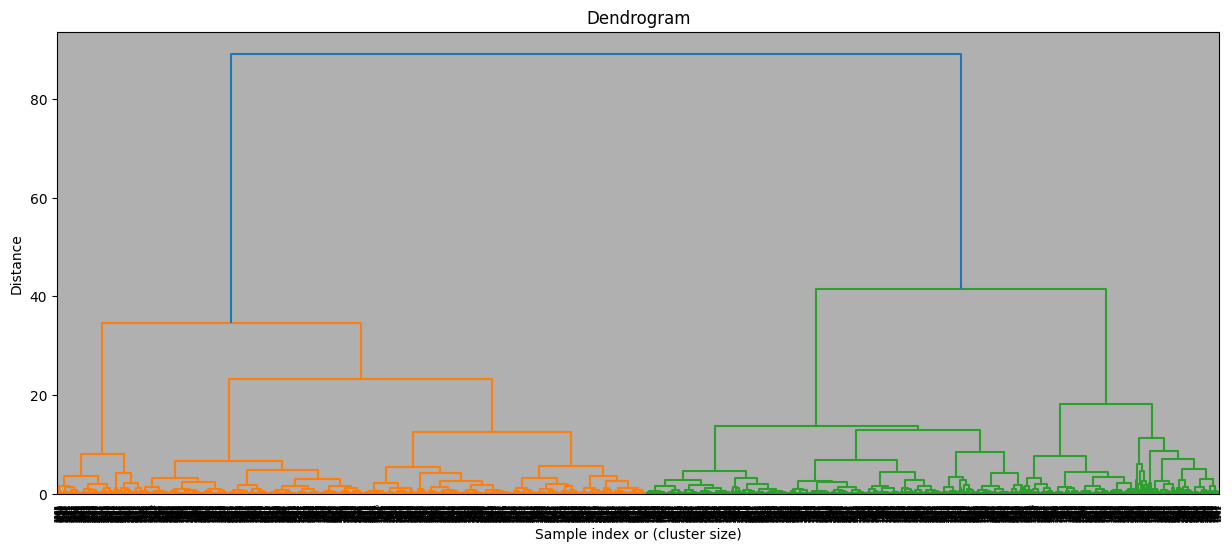

In [15]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

linked = linkage(normalized_features, method='ward')

plt.figure(figsize=(15, 6))
dendrogram(linked,
           truncate_mode='level',
           p=30,
           show_leaf_counts=True)
plt.title("Dendrogram")
plt.xlabel("Sample index or (cluster size)")
plt.ylabel("Distance")
plt.grid(True)
plt.show()


In [16]:
# Agglomerative Clustering
n_clusters = 2
hc = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
labels = hc.fit_predict(normalized_features)

# Evaluation
sil_score = silhouette_score(normalized_features, labels)
dbi_score = davies_bouldin_score(normalized_features, labels)
print(f"Silhouette Score: {sil_score:.4f}")
print(f"Davies-Bouldin Index: {dbi_score:.4f}")


Silhouette Score: 0.4940
Davies-Bouldin Index: 0.6956


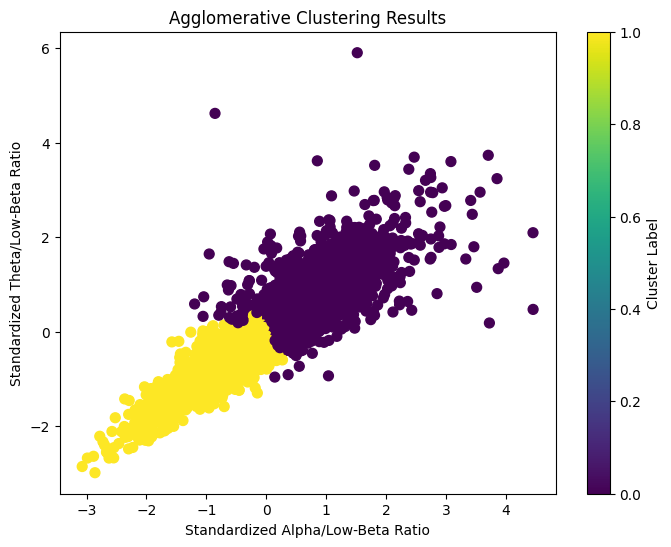

Cluster labels: [1 1 1 ... 1 0 1]


In [17]:
# Visualize the clusters (for 2D features)
plt.figure(figsize=(8, 6))
plt.scatter(normalized_features[:, 0], normalized_features[:, 1], c=labels, cmap='viridis', marker='o', s=50)
plt.title('Agglomerative Clustering Results')
plt.xlabel('Standardized Alpha/Low-Beta Ratio')
plt.ylabel('Standardized Theta/Low-Beta Ratio')
plt.colorbar(label='Cluster Label')
plt.show()

# Print cluster labels
print("Cluster labels:", labels)